In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from PIL import Image, ImageOps, ImageFile
from tensorflow.keras.preprocessing.image import img_to_array, load_img, save_img

# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

import os
from pathlib import Path
from collections import defaultdict


pd.plotting.register_matplotlib_converters()
%matplotlib inline

%load_ext autoreload
%autoreload 2
from help_tool import help_tool

# Setting graph parameters
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

In [2]:
base_dir = 'Archive/Mushrooms'
path = Path(base_dir)

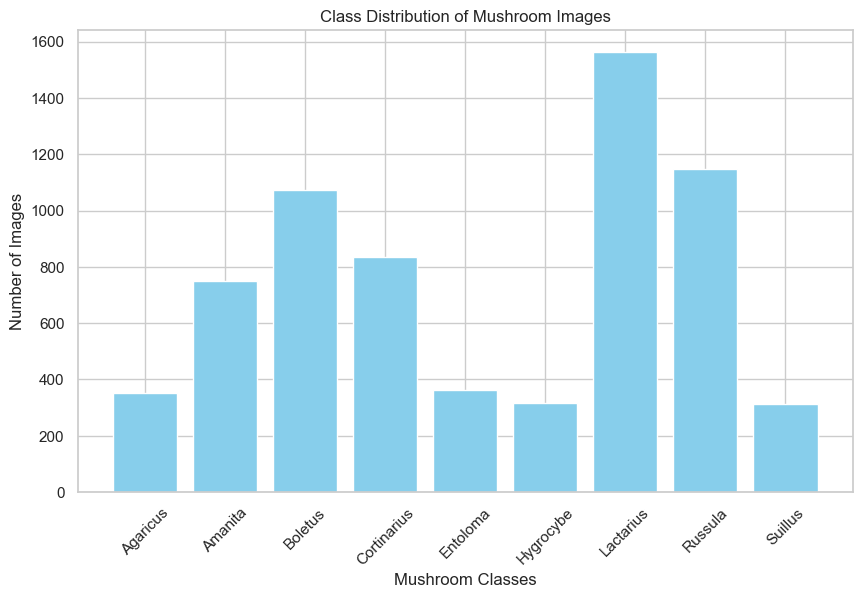

In [3]:
help_tool.plot_image_distribution(base_dir)

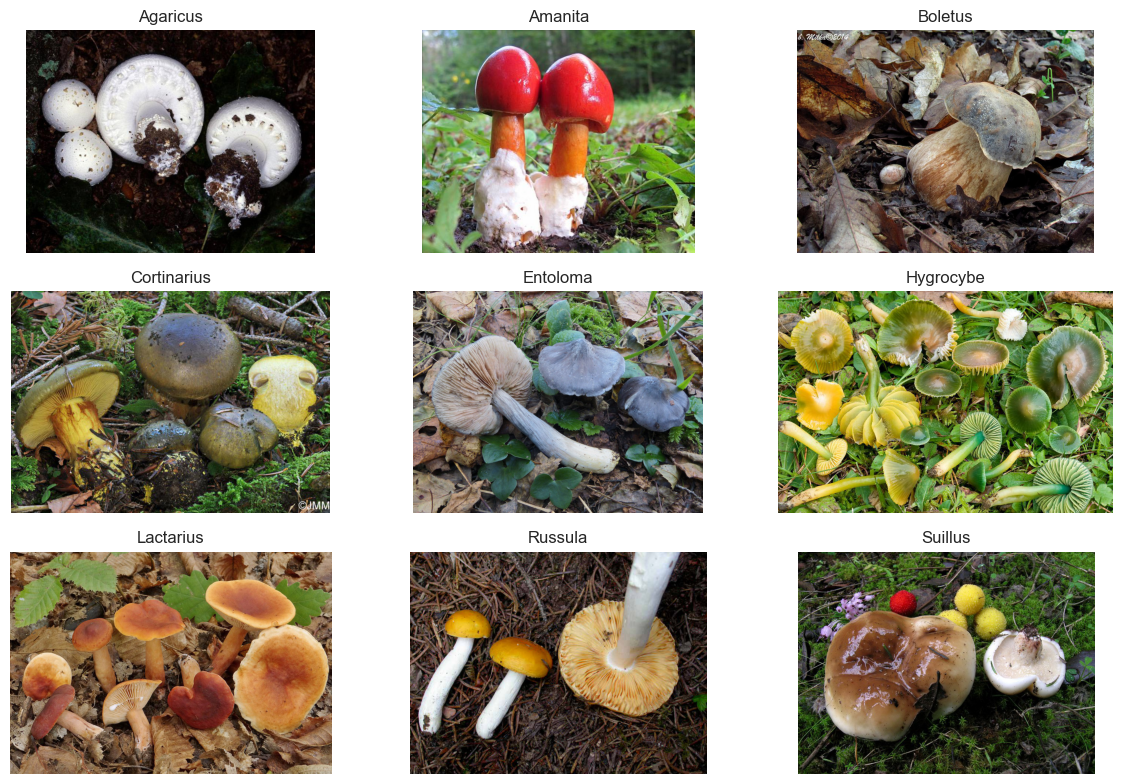

In [4]:
help_tool.visualize_sample_images(base_dir)

In [5]:
# def calculate_image_stats(base_dir):
#     class_folders = get_class_folders(base_dir)
#     stats = {}
    
#     for folder in class_folders:
#         images = [os.path.join(folder, img) for img in os.listdir(folder) if os.path.isfile(os.path.join(folder, img))]
#         dimensions = []
        
#         for image_path in images:
#             with Image.open(image_path) as img:
#                 dimensions.append(img.size)
        
#         if dimensions:
#             widths, heights = zip(*dimensions)
#             stats[os.path.basename(folder)] = {
#                 'count': len(dimensions),
#                 'min_width': min(widths),
#                 'max_width': max(widths),
#                 'min_height': min(heights),
#                 'max_height': max(heights),
#                 'avg_width': np.mean(widths),
#                 'avg_height': np.mean(heights)
#             }
    
#     return stats

# image_stats = calculate_image_stats(base_dir)
# for class_name, stats in image_stats.items():
#     print(f'Class: {class_name}')
#     print(f"  Count: {stats['count']}")
#     print(f"  Width: Min={stats['min_width']}, Max={stats['max_width']}, Avg={stats['avg_width']:.2f}")
#     print(f"  Height: Min={stats['min_height']}, Max={stats['max_height']}, Avg={stats['avg_height']:.2f}")
#     print()


# Image Dimensions by Class

In [6]:
size_df = help_tool.extract_and_combine_image_attributes(base_dir)
size_df.head()

ID     Class  Width  Height  File Size File Format Mode  \
0  000_ePQknW8cTp8.jpg  Agaricus    778     600      73476        JPEG  RGB   
1  001_2jP9N_ipAo8.jpg  Agaricus    700     525     166114        JPEG  RGB   
2  002_hNh3aQSH-ZM.jpg  Agaricus    700     524     141494        JPEG  RGB   
3  003_4AurAO4Jil8.jpg  Agaricus    800     600     184048        JPEG  RGB   
4  004_Syi3NxxviC0.jpg  Agaricus    750     563     107175        JPEG  RGB   

   ID_number  
0          0  
1          1  
2          2  
3          3  
4          4

In [7]:
size_df.shape

(6714, 8)

In [8]:
size_df[size_df.duplicated()].shape[0]

0

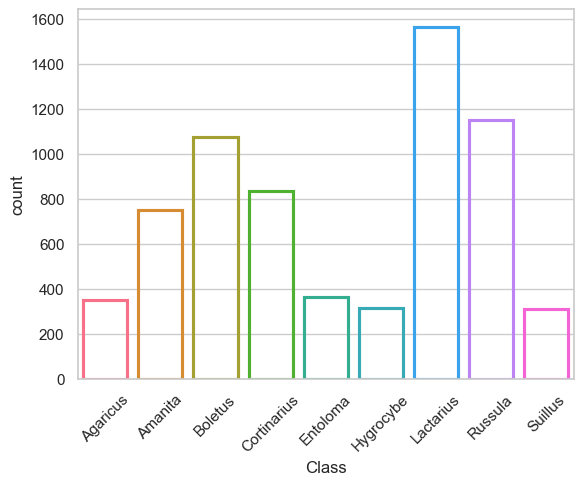

In [9]:
sns.countplot(data=size_df, x='Class', hue='Class', fill=False)
plt.xticks(rotation=45)
plt.show()

Width


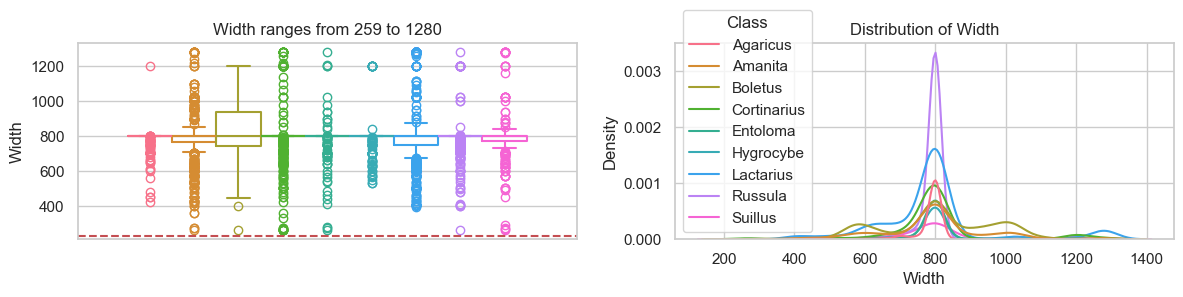

Height


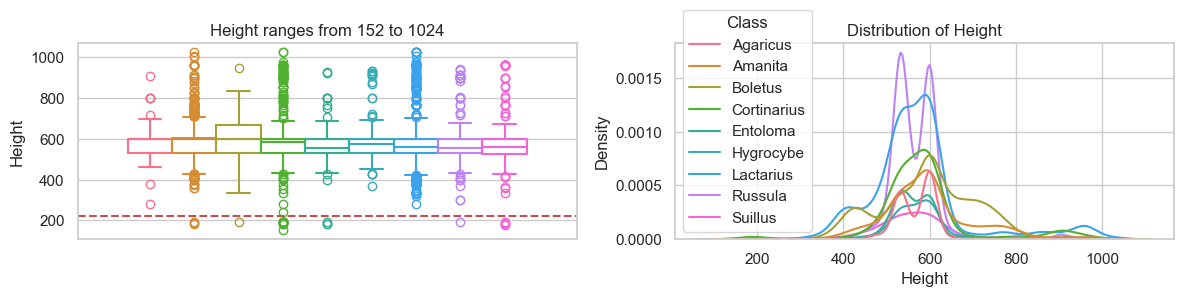

File Size


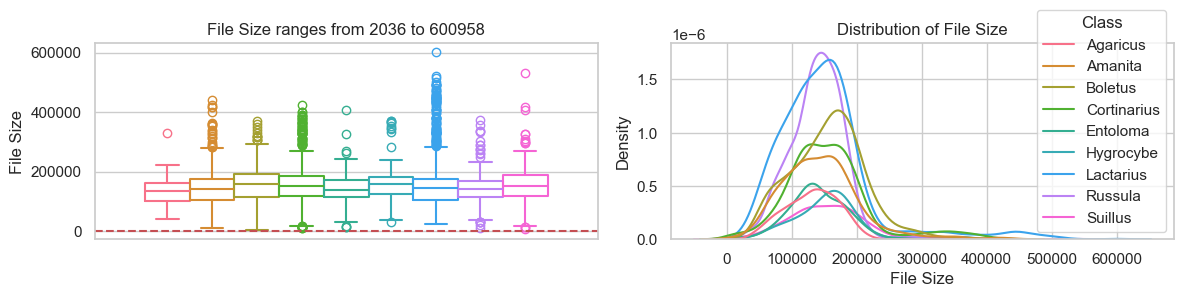

In [10]:
help_tool.distribution_check(size_df.drop(columns='ID_number'), 'Class')

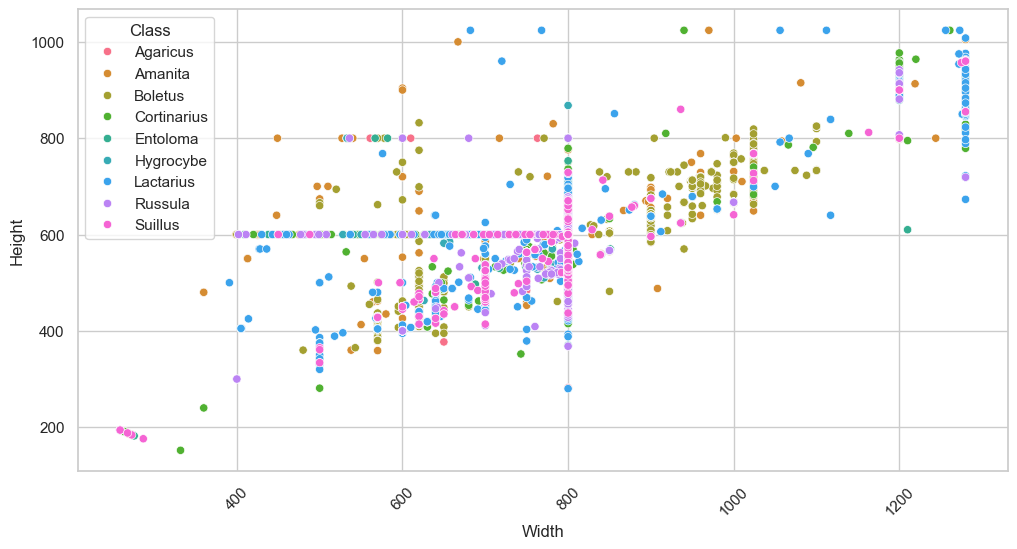

In [11]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=size_df, x='Width', y='Height', hue='Class')
plt.xticks(rotation=45)
plt.show()

* Mode L: Single-channel grayscale, more memory-efficient.
* Mode RGB: Three-channel color, providing richer color information but using more memory.

In [12]:
size_df[['File Format', 'Mode']].value_counts()

File Format  Mode
JPEG         RGB     6712
             L          2
Name: count, dtype: int64

## Bad images
### Encoded Black-White

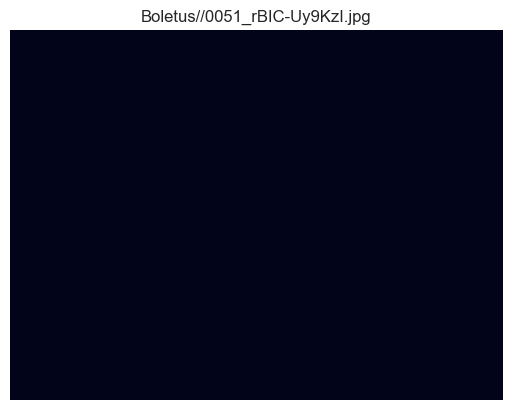

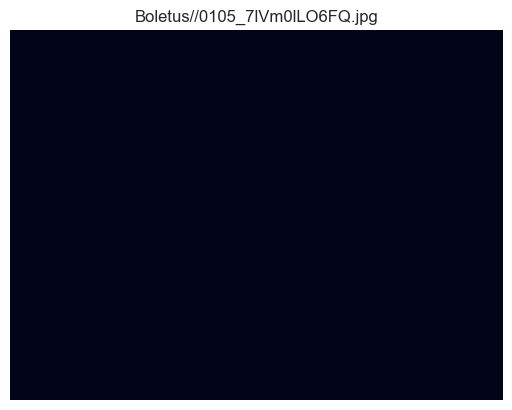

In [17]:
for index, row in size_df[size_df['Mode'] == 'L'].iterrows():
    image_path = f"{base_dir}/{row['Class']}//{row['ID']}"
    
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.title(f"{row['Class']}//{row['ID']}")
    plt.show()

In [18]:
bad_images = size_df[size_df['Mode'] == 'L']

### Duplicates

In [23]:
size_df[size_df['ID'].duplicated()]

Empty DataFrame
Columns: [ID, Class, Width, Height, File Size, File Format, Mode, ID_number]
Index: []

Correlation score for Red channel: 0.8165341286328394
Correlation score for Green channel: 0.8608299614291836
Correlation score for Blue channel: 0.8963978149546395


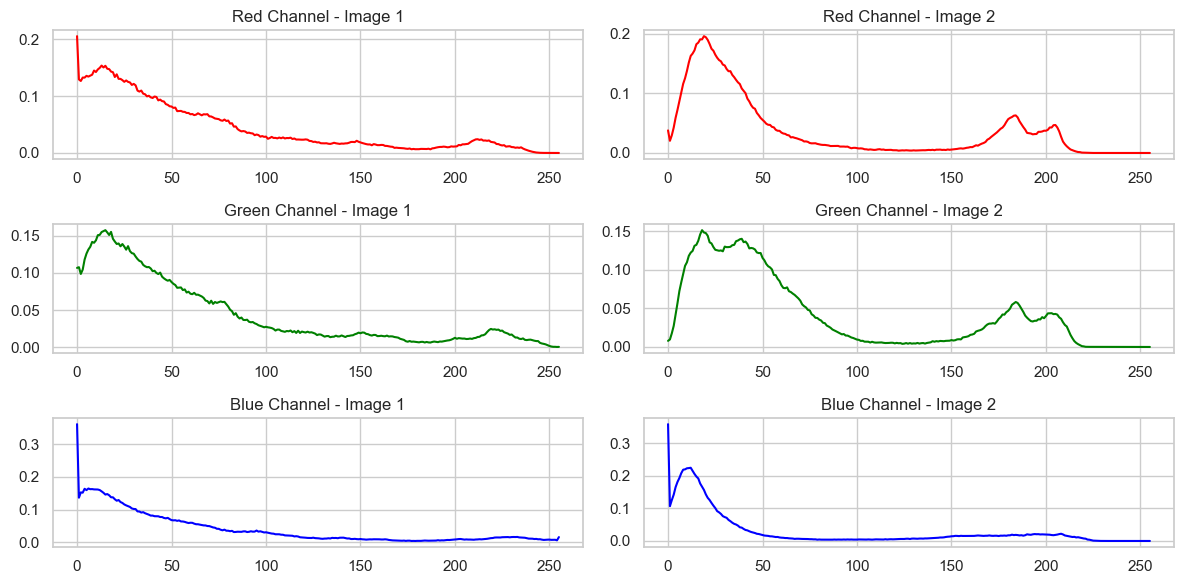

In [29]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def calculate_histogram(image_path):
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    # Convert image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Calculate histogram for each channel
    hist_r = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([image], [1], None, [256], [0, 256])
    hist_b = cv2.calcHist([image], [2], None, [256], [0, 256])

    # Normalize the histograms
    hist_r = cv2.normalize(hist_r, hist_r).flatten()
    hist_g = cv2.normalize(hist_g, hist_g).flatten()
    hist_b = cv2.normalize(hist_b, hist_b).flatten()

    return hist_r, hist_g, hist_b

def compare_histograms(image1_path, image2_path):
    # Calculate histograms for both images
    hist_r1, hist_g1, hist_b1 = calculate_histogram(image1_path)
    hist_r2, hist_g2, hist_b2 = calculate_histogram(image2_path)

    # Compare histograms using correlation method
    score_r = cv2.compareHist(hist_r1, hist_r2, cv2.HISTCMP_CORREL)
    score_g = cv2.compareHist(hist_g1, hist_g2, cv2.HISTCMP_CORREL)
    score_b = cv2.compareHist(hist_b1, hist_b2, cv2.HISTCMP_CORREL)

    # Print the comparison scores
    print(f"Correlation score for Red channel: {score_r}")
    print(f"Correlation score for Green channel: {score_g}")
    print(f"Correlation score for Blue channel: {score_b}")

    # Plot the histograms for visual comparison
    plt.figure(figsize=(12, 6))

    plt.subplot(3, 2, 1)
    plt.plot(hist_r1, color='red')
    plt.title('Red Channel - Image 1')

    plt.subplot(3, 2, 2)
    plt.plot(hist_r2, color='red')
    plt.title('Red Channel - Image 2')

    plt.subplot(3, 2, 3)
    plt.plot(hist_g1, color='green')
    plt.title('Green Channel - Image 1')

    plt.subplot(3, 2, 4)
    plt.plot(hist_g2, color='green')
    plt.title('Green Channel - Image 2')

    plt.subplot(3, 2, 5)
    plt.plot(hist_b1, color='blue')
    plt.title('Blue Channel - Image 1')

    plt.subplot(3, 2, 6)
    plt.plot(hist_b2, color='blue')
    plt.title('Blue Channel - Image 2')

    plt.tight_layout()
    plt.show()

# Example usage
compare_histograms('Archive\Mushrooms\Agaricus\\432_eLnDgepnPi0.jpg', 'Archive\Mushrooms\Agaricus\\440_w3SuRsQc4lY.jpg')


In [74]:
import os
import cv2
import numpy as np
import pandas as pd
from itertools import combinations

def calculate_histogram(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    hist_r = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([image], [1], None, [256], [0, 256])
    hist_b = cv2.calcHist([image], [2], None, [256], [0, 256])

    hist_r = cv2.normalize(hist_r, hist_r).flatten()
    hist_g = cv2.normalize(hist_g, hist_g).flatten()
    hist_b = cv2.normalize(hist_b, hist_b).flatten()

    return hist_r, hist_g, hist_b

def compare_histograms(hist1, hist2):
    score_r = cv2.compareHist(hist1[0], hist2[0], cv2.HISTCMP_CORREL)
    score_g = cv2.compareHist(hist1[1], hist2[1], cv2.HISTCMP_CORREL)
    score_b = cv2.compareHist(hist1[2], hist2[2], cv2.HISTCMP_CORREL)
    return (score_r + score_g + score_b) / 3  # Average score of RGB channels

def compare_images_in_directory(directory_path):
    image_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith(('jpg', 'jpeg', 'png'))]
    
    if len(image_files) < 2:
        print("Need at least two images to compare.")
        return

    histograms = {image_file: calculate_histogram(image_file) for image_file in image_files}

    comparison_results = []
    
    for img1, img2 in combinations(image_files, 2):
        score = compare_histograms(histograms[img1], histograms[img2])
        comparison_results.append((directory_path, os.path.basename(img1), os.path.basename(img2), score))

    comparison_results.sort(key=lambda x: x[3], reverse=True)

    # Convert to DataFrame
    df_results = pd.DataFrame(comparison_results, columns=['Location', 'Image1', 'Image2', 'SimilarityScore'])
    
    return df_results

# Example usage
directory_path = 'Archive\Mushrooms\Hygrocybe'
comparison_results_df = compare_images_in_directory(directory_path)

comparison_results_df.head(10)

Location               Image1               Image2  \
0  Archive\Mushrooms\Hygrocybe  088_WH4HC41vFQs.jpg  098_IYHEtcVrT4I.jpg   
1  Archive\Mushrooms\Hygrocybe  008_Hyfl4fSbciM.jpg  025_uRz3TTEwU1E.jpg   
2  Archive\Mushrooms\Hygrocybe  222_aXJOLcrg5Cg.jpg  223_dfs9-uyw1Os.jpg   
3  Archive\Mushrooms\Hygrocybe  006_wR0nc64hb7I.jpg  024_YThZh8Mwcp4.jpg   
4  Archive\Mushrooms\Hygrocybe  006_wR0nc64hb7I.jpg  118_pYAIRY-XOFs.jpg   
5  Archive\Mushrooms\Hygrocybe  024_YThZh8Mwcp4.jpg  223_dfs9-uyw1Os.jpg   
6  Archive\Mushrooms\Hygrocybe  012_LItejlRJ918.jpg  112_qr7hsvuhJZ0.jpg   
7  Archive\Mushrooms\Hygrocybe  193_LKj1qqQZcH4.jpg  290_fsSQ8aM2W7I.jpg   
8  Archive\Mushrooms\Hygrocybe  025_uRz3TTEwU1E.jpg  282_GCNiOz2vh5I.jpg   
9  Archive\Mushrooms\Hygrocybe  133_3_ieL2NtOF0.jpg  183_zmqUiH8R5Ws.jpg   

   SimilarityScore  
0         1.000000  
1         0.996252  
2         0.993701  
3         0.989243  
4         0.983611  
5         0.981928  
6         0.981323  
7         0.979919  
8         0.979321  
9         0.978860

The first image has a SimilarityScore of 1, it's the same picture, but the rest pictures are different in angle, composition.

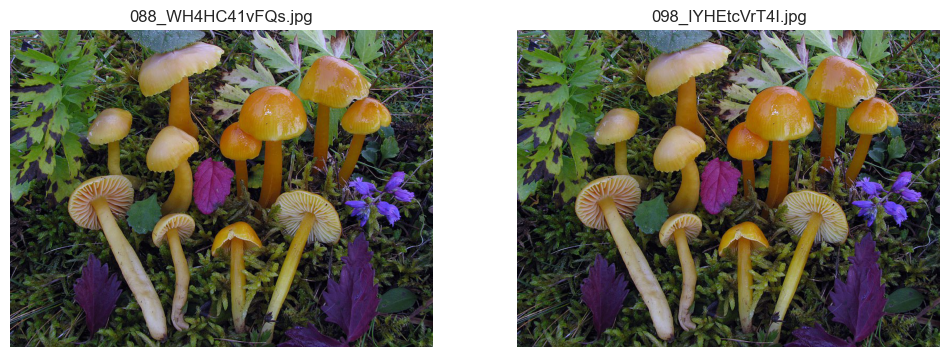

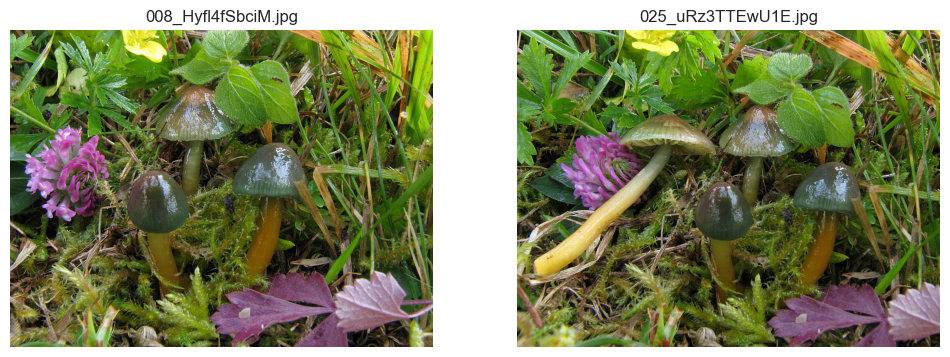

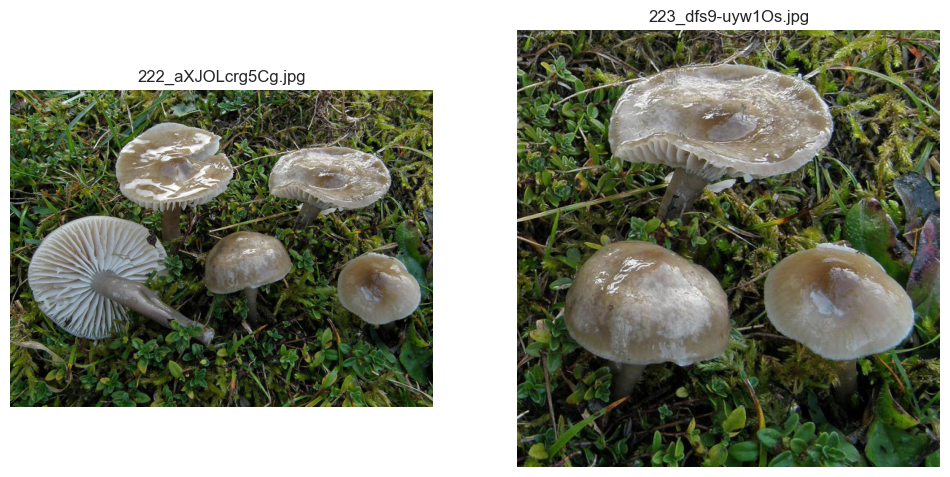

In [75]:
def display_image_pairs(df, base_path, num_pairs=1):
    for index, row in df.head(num_pairs).iterrows():
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        img1_path = os.path.join(base_path, row['Image1'])
        img2_path = os.path.join(base_path, row['Image2'])

        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)

        axes[0].imshow(img1)
        axes[0].axis('off')
        axes[0].set_title(f"{row['Image1']}")

        axes[1].imshow(img2)
        axes[1].axis('off')
        axes[1].set_title(f"{row['Image2']}")

        plt.show()

# Example usage
base_path = 'Archive/Mushrooms/Hygrocybe'
display_image_pairs(comparison_results_df, base_path, num_pairs=3)

In [92]:
duplicated_images = pd.DataFrame(columns=['Location', 'Image1', 'Image2', 'SimilarityScore'])

for class_folder in os.scandir(base_dir):
    if class_folder.is_dir():  
        class_folder_path = class_folder.path

        # Get comparison results for the current directory
        comparison_results_df = compare_images_in_directory(class_folder_path)
        
        # Filter out rows where 'SimilarityScore' equals 1
        filtered_df = comparison_results_df[comparison_results_df['SimilarityScore'] == 1].copy()

        # Ensure filtered_df is not empty before concatenation
        if not filtered_df.empty:
            # Add the location column using .loc
            filtered_df.loc[:, 'Location'] = class_folder.name

            # Ensure columns match and avoid concatenating empty columns
            filtered_df = filtered_df[['Location', 'Image1', 'Image2', 'SimilarityScore']]
            duplicated_images = pd.concat([duplicated_images, filtered_df], ignore_index=True)


duplicated_images


C:\Users\Gintare\AppData\Local\Temp\ipykernel_14732\4256095492.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  duplicated_images = pd.concat([duplicated_images, filtered_df], ignore_index=True)


Location                Image1                Image2  SimilarityScore
0    Agaricus   151_QKzgc9MO9LM.jpg   152_uLPPbLUrAro.jpg              1.0
1    Agaricus   180_eZSp7CXrIps.jpg   181_42srgvDitnE.jpg              1.0
2     Amanita   139_2tM1nrJmAeY.jpg   140_2tM1nrJmAeY.jpg              1.0
3     Amanita   732__6NHENIp15Y.jpg   765_EloICHZR9ow.jpg              1.0
4     Boletus  0051_rBIC-Uy9KzI.jpg  0105_7lVm0lLO6FQ.jpg              1.0
..        ...                   ...                   ...              ...
64  Lactarius  1088_LTKVGNRHRws.jpg  1113_4RfOmFyXPus.jpg              1.0
65  Lactarius   306_-z5VDV-LUtU.jpg   312_Kxi6Fhuexdw.jpg              1.0
66  Lactarius   390__SiJRKdnWig.jpg   393_1qWp8lGcF3o.jpg              1.0
67    Russula   036_8o2UIeIHnSM.jpg   037_rK-CY5DSWpQ.jpg              1.0
68    Russula   448_EjNRPvABLWs.jpg   449_EjNRPvABLWs.jpg              1.0

[69 rows x 4 columns]

In [94]:
duplicated_images.shape

(69, 4)

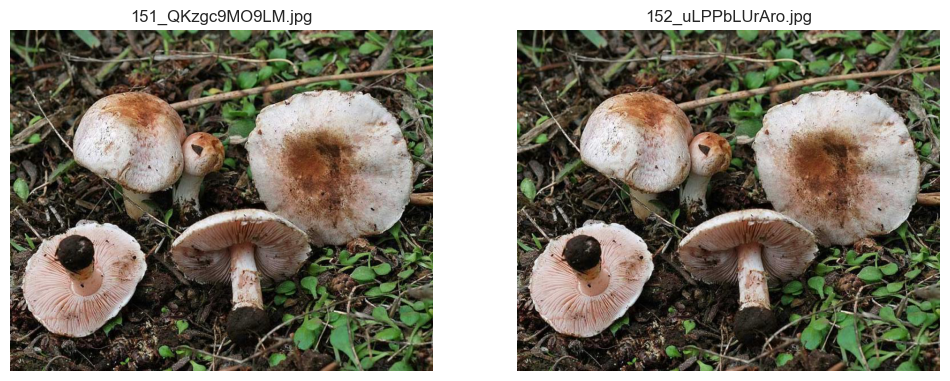

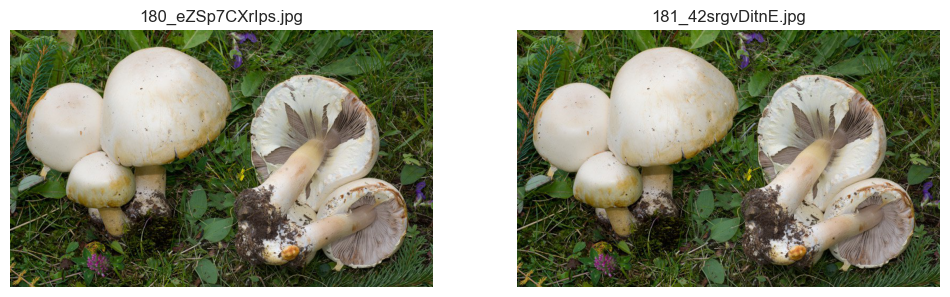

In [95]:
base_path = 'Archive/Mushrooms/Agaricus'
display_image_pairs(duplicated_images[duplicated_images['Location'] == 'Agaricus'], base_path, num_pairs=2)

In [102]:
duplicated_images[['Location', 'Image1']].head()

Location                Image1
0  Agaricus   151_QKzgc9MO9LM.jpg
1  Agaricus   180_eZSp7CXrIps.jpg
2   Amanita   139_2tM1nrJmAeY.jpg
3   Amanita   732__6NHENIp15Y.jpg
4   Boletus  0051_rBIC-Uy9KzI.jpg

In [97]:
size_df

ID     Class  Width  Height  File Size File Format  \
0     000_ePQknW8cTp8.jpg  Agaricus    778     600      73476        JPEG   
1     001_2jP9N_ipAo8.jpg  Agaricus    700     525     166114        JPEG   
2     002_hNh3aQSH-ZM.jpg  Agaricus    700     524     141494        JPEG   
3     003_4AurAO4Jil8.jpg  Agaricus    800     600     184048        JPEG   
4     004_Syi3NxxviC0.jpg  Agaricus    750     563     107175        JPEG   
...                   ...       ...    ...     ...        ...         ...   
6709  332_yhuZkvWUHSw.jpg   Suillus   1024     712     223578        JPEG   
6710  333_A-T3_wkjwCk.jpg   Suillus   1024     768     219795        JPEG   
6711  334_tepwic_Btvc.jpg   Suillus   1024     768     202508        JPEG   
6712  335_n1jQ-n_Pb4U.jpg   Suillus   1200     900     310595        JPEG   
6713  336_ujDTEEWsRc8.jpg   Suillus   1280     960     325076        JPEG   

     Mode  ID_number  
0     RGB          0  
1     RGB          1  
2     RGB          2  
3     RGB          3  
4     RGB          4  
...   ...        ...  
6709  RGB        332  
6710  RGB        333  
6711  RGB        334  
6712  RGB        335  
6713  RGB        336  

[6714 rows x 8 columns]

In [103]:
import duckdb

In [117]:
bad_image_list = duckdb.query("""
             SELECT * FROM bad_images

             UNION

             SELECT A.* 
             FROM size_df A
             RIGHT JOIN duplicated_images B
             ON A.Class=B.Location AND A.ID=B.Image1            

""").to_df()

bad_image_list.shape

(70, 8)

In [118]:
bad_image_list.head()

ID      Class  Width  Height  File Size File Format Mode  \
0  0026_autPTj6WXpU.jpg  Lactarius    800     474     153605        JPEG  RGB   
1  0030_i2ZcdNrZWwM.jpg  Lactarius    800     597     182023        JPEG  RGB   
2  0060_zbOQxCzhd4I.jpg  Lactarius    760     570     177141        JPEG  RGB   
3  0063_cydiqZLsahM.jpg  Lactarius    800     532     157987        JPEG  RGB   
4  0076_EzLb5aAPwdo.jpg  Lactarius    800     531     203134        JPEG  RGB   

   ID_number  
0         26  
1         30  
2         60  
3         63  
4         76

# What is the RGB distribution of small pictures?

In [31]:
classes

['Agaricus',
 'Amanita',
 'Boletus',
 'Cortinarius',
 'Entoloma',
 'Hygrocybe',
 'Lactarius',
 'Russula',
 'Suillus']

In [54]:
size_df['Class'].value_counts().min()

311

# Bad images

In [41]:
size_df[~size_df['ID'].str.endswith('jpg')]

Empty DataFrame
Columns: [ID, Class, Width, Height, ID_number]
Index: []

In [46]:
size_df[size_df['ID'].str.split('_', expand=True)[3].notna()]

ID     Class  Width  Height  ID_number
50    061__er6hwL4Y_M.jpg  Agaricus    700     467         61
156   190_qDzeyg_X_Ek.jpg  Agaricus    800     600        190
282   357__w_XUQZMZEw.jpg  Agaricus    800     600        357
414   065___89Jr1wGgc.jpg   Amanita    800     536         65
580   238_7M5xzSG_g_A.jpg   Amanita    900     643        238
...                   ...       ...    ...     ...        ...
5893  412_hK_N_vllKHo.jpg   Russula    800     539        412
5951  445_azGs_OyT_bs.jpg   Russula    800     533        445
6389  782_X_fag_D5VqU.jpg   Russula    800     576        782
6390  783_GUlaRl__rBo.jpg   Russula    800     600        783
6469  076_eqA9_q6_9JU.jpg   Suillus    800     531         76

[62 rows x 5 columns]

In [59]:
size_df['Class'].value_counts()

Class
Lactarius      1563
Russula        1148
Boletus        1073
Cortinarius     836
Amanita         750
Entoloma        364
Agaricus        353
Hygrocybe       316
Suillus         311
Name: count, dtype: int64

In [55]:
sample_size = size_df['Class'].value_counts().min()

In [61]:
sample_size - 1

310

In [63]:
import os
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [70]:
base_dir

'Archive/Mushrooms'

In [68]:
output_dir = 'Archive/Dataset_Split'

# Create output directories
for split in ['train', 'val', 'test']:
    for subfolder in classes:
        os.makedirs(os.path.join(output_dir, split, subfolder), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'all'), exist_ok=True)
    for subfolder in classes:
        os.makedirs(os.path.join(output_dir, 'all', subfolder), exist_ok=True)


In [72]:
import random
import shutil

def sample_images(src_folder, dest_folder, num_samples):
    images = os.listdir(src_folder)
    # Check if there are enough images to sample
    if len(images) < num_samples:
        print(f"Warning: Not enough images in {src_folder}. Found {len(images)}, sampling all.")
        num_samples = len(images)
    sampled_images = random.sample(images, num_samples)
    for img_name in sampled_images:
        shutil.copy(os.path.join(src_folder, img_name), os.path.join(dest_folder, img_name))

# Sample 300 images from each subfolder and save them
for subfolder in classes:
    src_folder = os.path.join(base_dir, subfolder)
    dest_folder = os.path.join(output_dir, 'all', subfolder)
    sample_images(src_folder, dest_folder, 300)


In [47]:
import keras

In [52]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

image_size = (180, 180)
batch_size = 128

train_ds = image_dataset_from_directory(
    base_dir,
    validation_split=0.3,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = image_dataset_from_directory(
    base_dir,
    validation_split=0.3,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)


Found 5611 files belonging to 9 classes.
Using 3928 files for training.
Found 5611 files belonging to 9 classes.
Using 1683 files for validation.


In [53]:
class_names = train_ds.class_names
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")

Number of classes: 9
Class names: ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']


In [26]:
# def extract_dimensions_from_folder(folder_path):
#     """Extract image dimensions (width, height) from a folder."""
#     widths = []
#     heights = []
    
#     images = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, img))]
#     for image_path in images:
#         with Image.open(image_path) as img:
#             width, height = img.size
#             widths.append(width)
#             heights.append(height)
    
#     return widths, heights


# def plot_image_dimensions(base_dir):
#     class_folders = get_class_folders(base_dir)
    
#     plt.figure(figsize=(14, 10))
    
#     for folder in class_folders:
#         class_name = os.path.basename(folder)
#         widths, heights = extract_dimensions_from_folder(folder)
        
#         if widths and heights:
#             plt.scatter(widths, heights, label=class_name, alpha=0.5, s=10)  # Adjust alpha and s for better visibility
    
#     plt.xlabel('Width')
#     plt.ylabel('Height')
#     plt.title('Image Dimensions by Class')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# plot_image_dimensions('Archive/Mushrooms')

# Resizing Images

In [25]:
def resize_and_pad(image_path, output_path, size=(224, 224), padding_color=(0, 0, 0)):
    """Resize an image to fit within the given size and pad the remaining space."""
    with Image.open(image_path) as img:
        # Resize the image while maintaining aspect ratio
        img.thumbnail(size, Image.LANCZOS)
        
        # Create a new image with the desired size and padding color
        padded_img = Image.new('RGB', size, padding_color)
        
        # Calculate the position to paste the resized image onto the padded image
        paste_position = ((size[0] - img.size[0]) // 2, (size[1] - img.size[1]) // 2)
        
        # Paste the resized image onto the padded image
        padded_img.paste(img, paste_position)
        
        # Save the final image
        padded_img.save(output_path)


In [23]:
def resize_images_in_class_folders(base_dir, output_base_dir, size=(224, 224), padding_color=(0, 0, 0)):
    """Resize images in each class folder and save them to the output directory."""
    class_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
    
    for class_folder in class_folders:
        input_folder = os.path.join(base_dir, class_folder)
        output_folder = os.path.join(output_base_dir, class_folder)
        
        # Create the output folder if it doesn't exist
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        
        # Process each image in the class folder
        for image_file in os.listdir(input_folder):
            input_image_path = os.path.join(input_folder, image_file)
            output_image_path = os.path.join(output_folder, image_file)
            resize_and_pad(input_image_path, output_image_path, size, padding_color)

        print(f'Resized images in class folder: {class_folder}')


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define augmentation parameters
datagen = ImageDataGenerator(
    zoom_range=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_images(input_folder, output_folder, augmentations_per_image=5):
    """Augment images from the input folder and save them to the output folder."""
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through each image in the input folder
    for image_file in os.listdir(input_folder):
        img_path = os.path.join(input_folder, image_file)
        img = load_img(img_path)
        x = img_to_array(img)  # Convert image to numpy array
        x = x.reshape((1,) + x.shape)  # Reshape to (1, height, width, channels)

        # Generate batches of augmented images
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=output_folder, save_prefix='aug', save_format='jpeg'):
            i += 1
            if i >= augmentations_per_image:  # Generate the specified number of augmentations
                break

# Example usage
base_dir = 'Archive/Mushrooms'
output_base_dir = 'Archive/Resized_Mushrooms'

resize_images_in_class_folders(base_dir, output_base_dir)
for class_folder in os.listdir(output_base_dir):
    input_folder = os.path.join(output_base_dir, class_folder)
    output_folder = os.path.join('Archive/Augmented_Mushrooms', class_folder)
    augment_images(input_folder, output_folder)


Resized images in class folder: Agaricus
Resized images in class folder: Amanita
Resized images in class folder: Boletus
Resized images in class folder: Cortinarius
Resized images in class folder: Entoloma
Resized images in class folder: Hygrocybe
Resized images in class folder: Lactarius
Resized images in class folder: Russula
Resized images in class folder: Suillus


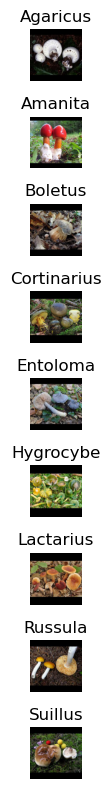

In [20]:
visualize_sample_images('Archive/Resized_Mushrooms')

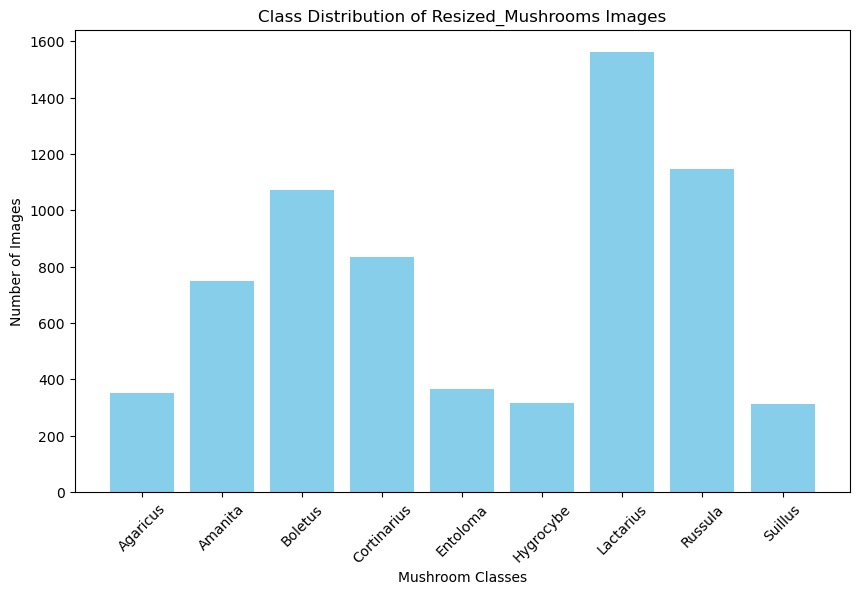

In [24]:
class_distribution = count_images_in_folders('Archive/Resized_Mushrooms')

# Convert the class distribution dictionary to lists for plotting
classes = list(class_distribution.keys())
counts = list(class_distribution.values())

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Mushroom Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution of Resized_Mushrooms Images')
plt.xticks(rotation=45)
plt.show()


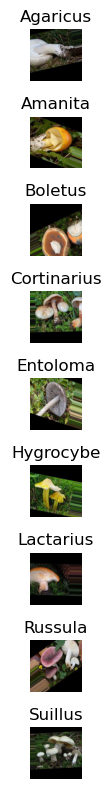

In [21]:
visualize_sample_images('Archive/Augmented_Mushrooms')

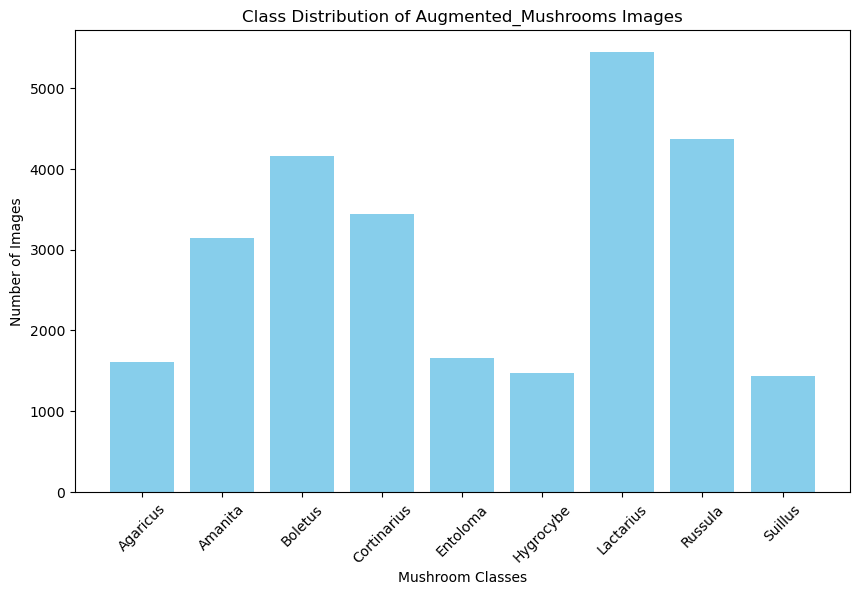

In [25]:
class_distribution = count_images_in_folders('Archive/Augmented_Mushrooms')

# Convert the class distribution dictionary to lists for plotting
classes = list(class_distribution.keys())
counts = list(class_distribution.values())

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Mushroom Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution of Augmented_Mushrooms Images')
plt.xticks(rotation=45)
plt.show()


# Data Partition

In [83]:
import os
import shutil
import numpy as np

def create_partition_directories(base_dir, partitions):
    """Create directories for train, validate, and test sets."""
    for partition in partitions:
        partition_dir = os.path.join(base_dir, partition)
        if not os.path.exists(partition_dir):
            os.makedirs(partition_dir)

def get_image_files(class_folder):
    """Get list of image files in the class folder."""
    return [os.path.join(class_folder, f) for f in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, f))]

def split_data(class_files, num_train, num_val, num_test):
    """Split files into train, validate, and test sets."""
    np.random.shuffle(class_files)
    train_files = class_files[:num_train]
    val_files = class_files[num_train:num_train + num_val]
    test_files = class_files[num_train + num_val:num_train + num_val + num_test]
    return train_files, val_files, test_files

def partition_dataset(base_dir, output_base_dir, num_train, num_val, num_test):
    """Partition the dataset into train, validate, and test sets."""
    partitions = ['train', 'validate', 'test']
    create_partition_directories(output_base_dir, partitions)
    
    class_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
    
    min_class_size = float('inf')
    
    # Determine the size of the smallest class
    for class_folder in class_folders:
        class_folder_path = os.path.join(base_dir, class_folder)
        num_images = len(get_image_files(class_folder_path))
        min_class_size = min(min_class_size, num_images)
    
    # Calculate the number of samples to take for each partition
    num_train_samples = int(min_class_size * num_train)
    num_val_samples = int(min_class_size * num_val)
    num_test_samples = int(min_class_size * num_test)
    
    for class_folder in class_folders:
        class_folder_path = os.path.join(base_dir, class_folder)
        class_files = get_image_files(class_folder_path)
        
        # Ensure balanced class sizes
        if len(class_files) > min_class_size:
            class_files = np.random.choice(class_files, min_class_size, replace=False)
        
        train_files, val_files, test_files = split_data(class_files, num_train_samples, num_val_samples, num_test_samples)
        
        for file_list, partition in zip([train_files, val_files, test_files], partitions):
            partition_folder = os.path.join(output_base_dir, partition, class_folder)
            if not os.path.exists(partition_folder):
                os.makedirs(partition_folder)
            for file in file_list:
                shutil.copy(file, os.path.join(partition_folder, os.path.basename(file)))

# Parameters
#base_dir = 'Archive/Augmented_Mushrooms'  # The directory containing the class folders
output_base_dir = 'Archive/Partitioned_Dataset'  # The directory to save train/validate/test sets

# Define the proportions of each set
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Ensure that the ratios sum up to 1
assert (train_ratio + val_ratio + test_ratio) == 1.0, "The sum of train, validate, and test ratios must be 1."

# Partition the dataset
partition_dataset(base_dir, output_base_dir, train_ratio, val_ratio, test_ratio)


In [81]:
base_dir

'Archive/Mushrooms'

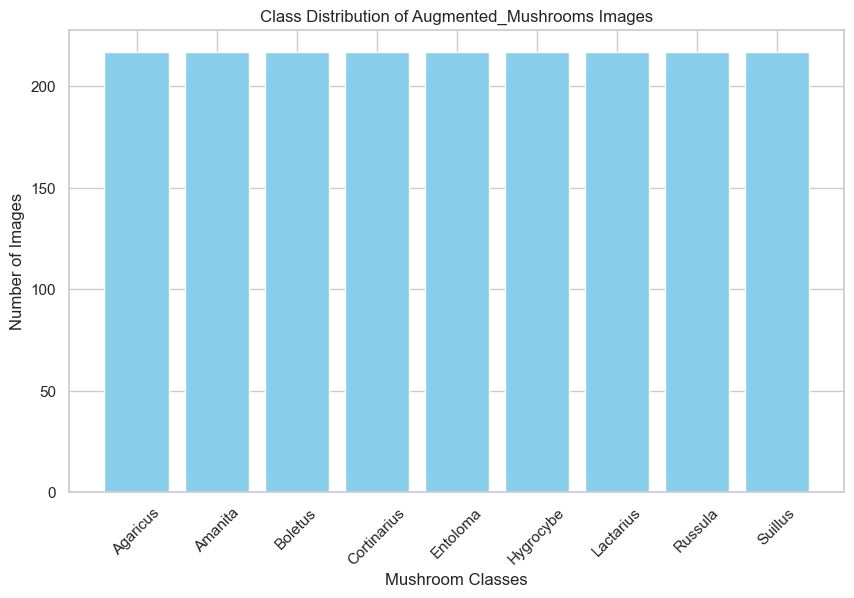

In [5]:
class_distribution = count_images_in_folders('Archive/Partitioned_Dataset/train')

# Convert the class distribution dictionary to lists for plotting
classes = list(class_distribution.keys())
counts = list(class_distribution.values())

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Mushroom Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution of Augmented_Mushrooms Images')
plt.xticks(rotation=45)
plt.show()


1. Create df with train/validate/test image names
2. Check which are missing
3. Add missing to Train Set
4. Add altered to smaller datasets

In [11]:
def partition_name(dir):
    # List to store all image data
    all_image_data = []

    # Get all class folders
    class_folders = get_class_folders(dir)

    # Extract dimensions and other metadata from each class folder
    for folder in class_folders:
        image_data = extract_dimensions_from_folder(folder)
        all_image_data.extend(image_data)

    # Create a DataFrame from the collected data
    df = pd.DataFrame(all_image_data)

    # Display the DataFrame
    return df


test_set = partition_name('Archive\Partitioned_Dataset\\test')
train_set = partition_name('Archive\Partitioned_Dataset\\train')
validate_set = partition_name('Archive\Partitioned_Dataset\\validate')

In [14]:
chossen_pics = pd.concat([test_set, train_set, validate_set])

In [21]:
chossen_pics

ID     Class  Width  Height
0    002_hNh3aQSH-ZM.jpg  Agaricus    700     524
1    006_1_E6AXBJqn4.jpg  Agaricus    800     600
2    028_-vDPakMKna4.jpg  Agaricus    800     600
3    031_uk4-mPGpINU.jpg  Agaricus    800     600
4    040_1g_auGYdtfU.jpg  Agaricus    800     516
..                   ...       ...    ...     ...
409  301_mQrDcp557zA.jpg   Suillus    800     529
410  306_DNNTel4Uu4E.jpg   Suillus    800     542
411  307_mkdzSUWNsyg.jpg   Suillus    800     532
412  319_K_k9RGBTGgs.jpg   Suillus    650     435
413  321_rwEHvE282zY.jpg   Suillus    800     600

[2781 rows x 4 columns]

In [20]:
size_df

ID     Class  Width  Height
0     000_ePQknW8cTp8.jpg  Agaricus    778     600
1     001_2jP9N_ipAo8.jpg  Agaricus    700     525
2     002_hNh3aQSH-ZM.jpg  Agaricus    700     524
3     003_4AurAO4Jil8.jpg  Agaricus    800     600
4     004_Syi3NxxviC0.jpg  Agaricus    750     563
...                   ...       ...    ...     ...
6709  332_yhuZkvWUHSw.jpg   Suillus   1024     712
6710  333_A-T3_wkjwCk.jpg   Suillus   1024     768
6711  334_tepwic_Btvc.jpg   Suillus   1024     768
6712  335_n1jQ-n_Pb4U.jpg   Suillus   1200     900
6713  336_ujDTEEWsRc8.jpg   Suillus   1280     960

[6714 rows x 4 columns]

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define augmentation parameters
datagen = ImageDataGenerator(
    zoom_range=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_images(input_folder, output_folder, augmentations_per_image=5):
    """Augment images from the input folder and save them to the output folder."""
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through each image in the input folder
    for image_file in os.listdir(input_folder):
        img_path = os.path.join(input_folder, image_file)
        img = load_img(img_path)
        x = img_to_array(img)  # Convert image to numpy array
        x = x.reshape((1,) + x.shape)  # Reshape to (1, height, width, channels)

        # Generate batches of augmented images
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=output_folder, save_prefix='aug', save_format='jpeg'):
            i += 1
            if i >= augmentations_per_image:  # Generate the specified number of augmentations
                break


resize_images_in_class_folders(base_dir, output_base_dir)
for class_folder in os.listdir(output_base_dir):
    input_folder = os.path.join('Archive\Partitioned_Dataset\\train', class_folder)
    output_folder = os.path.join('Archive\Augmented_Mushrooms', class_folder)
    augment_images(input_folder, output_folder)


NameError: name 'resize_images_in_class_folders' is not defined